In [1]:
using Revise

In [2]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using Blink
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models

INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/learning-mpc-2/packages/lib/v0.6/LCPSim.ji for module LCPSim.
INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/learning-mpc-2/packages/lib/v0.6/LearningMPC.ji for module LearningMPC.


In [3]:
robot = BoxAtlas()
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 8033`, ProcessRunning), TCPSocket(RawFD(51) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#3))), Blink.Page(1, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(56) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#3)), Future(1, 1, 1, Nullable{Any}(true))))

In [4]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params, false)
net, loss = LearningMPC.interval_net([22, 128, 128, 1])
optimizer = Flux.ADAM(Flux.params(net))

net_cost = LearningMPC.LearnedCost(lqrsol, net)

net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_mpc_controller]);

lqr_mpc_controller = MPCController(robot, (p = MPCParams(robot); p.horizon=1; p), lqrsol, [lqrsol])

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(::MPCController) (generic function with 1 method)

In [5]:
sample_sink = LearningMPC.MPCSampleSink{Float64}(true)
playback_sink = LearningMPC.PlaybackSink{Float64}(mvis)

full_mpc_controller.callback = LearningMPC.call_each(
    sample_sink,
    playback_sink,
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.call_each(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_mpc_controller,
        0.2),
    live_viewer
    )

dataset = LearningMPC.Dataset(lqrsol)

x_init = nominal_state(robot)

function collect_into!(data::Vector{<:LearningMPC.Sample}, σv)
    empty!(sample_sink)
    LearningMPC.randomize!(x0, x_init, 0.0, σv)
    results = LCPSim.simulate(x0, 
        dagger_controller,
        robot.environment, params.Δt, 100, 
        params.lcp_solver;
        termination=x -> configuration(x)[3] > π/4 || configuration(x)[3] < -π/4);
    append!(data, sample_sink.samples)
end

x0 = MechanismState{Float64}(robot.mechanism)

features(s::LearningMPC.Sample) = (s.state, s.mip.objective_bound, s.mip.objective_value)

features (generic function with 1 method)

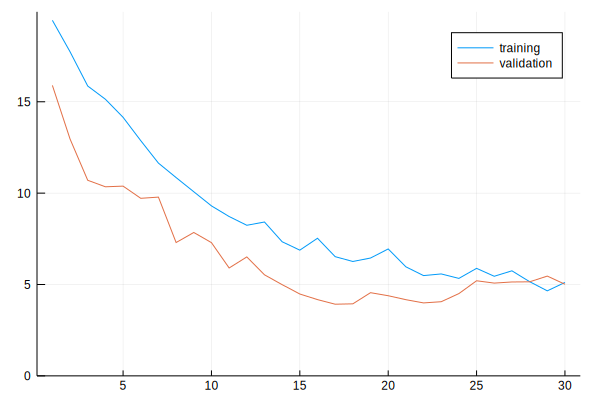

  7.428172 seconds (2.03 M allocations: 164.510 MiB, 1.15% gc time)


Progress:   1%|                                         |  ETA: 1 days, 6:06:14

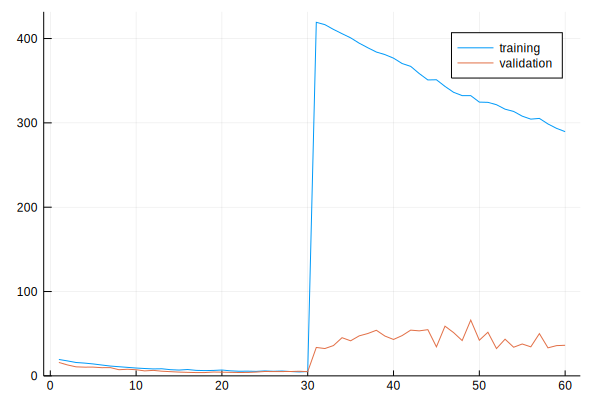

  5.339495 seconds (1.06 M allocations: 147.123 MiB, 1.10% gc time)


Progress:   2%|█                                        |  ETA: 20:32:50

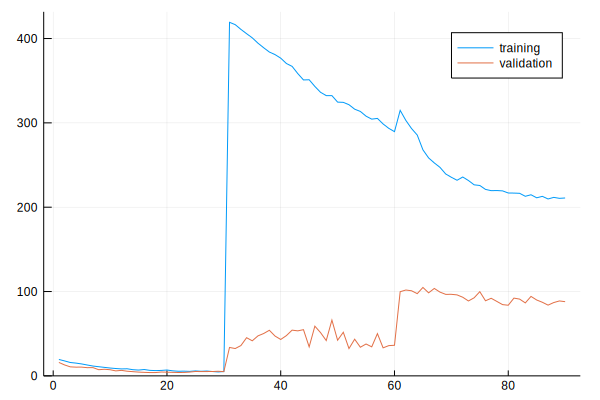

  6.192675 seconds (1.24 M allocations: 170.911 MiB, 1.39% gc time)


Progress:   3%|█                                        |  ETA: 15:16:13

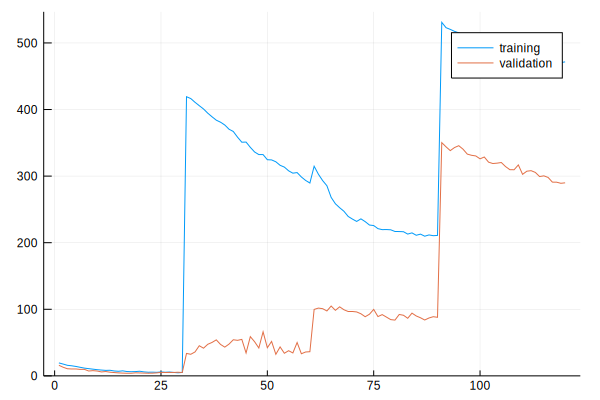

  6.765519 seconds (1.48 M allocations: 205.053 MiB, 1.21% gc time)


Progress:   4%|██                                       |  ETA: 14:05:40

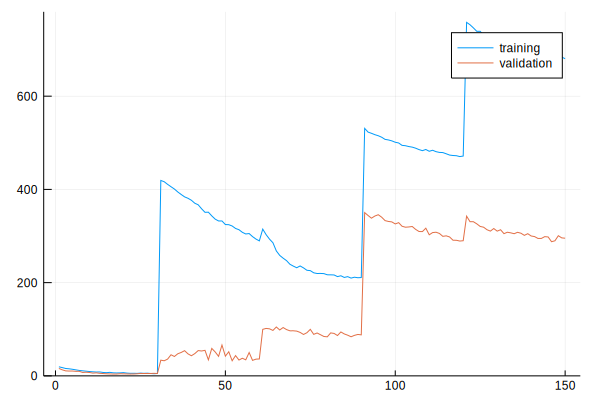

 10.878725 seconds (1.67 M allocations: 232.677 MiB, 1.06% gc time)


Progress:   5%|██                                       |  ETA: 12:46:14

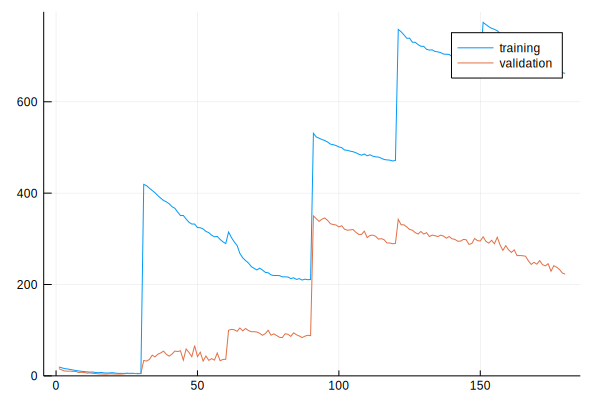

 14.033962 seconds (1.79 M allocations: 248.719 MiB, 1.37% gc time)


Progress:   6%|██                                       |  ETA: 11:20:50

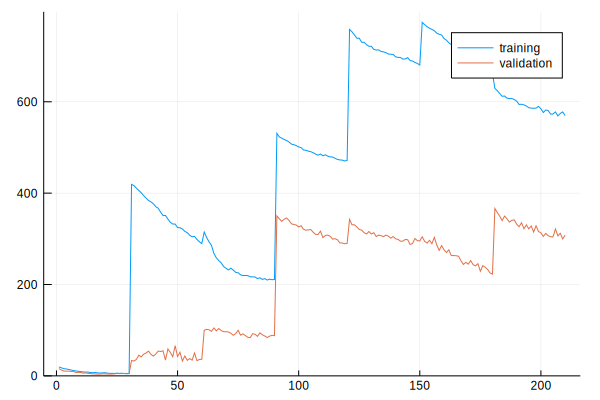

  8.891681 seconds (1.96 M allocations: 272.786 MiB, 1.09% gc time)


Progress:   7%|███                                      |  ETA: 10:29:14

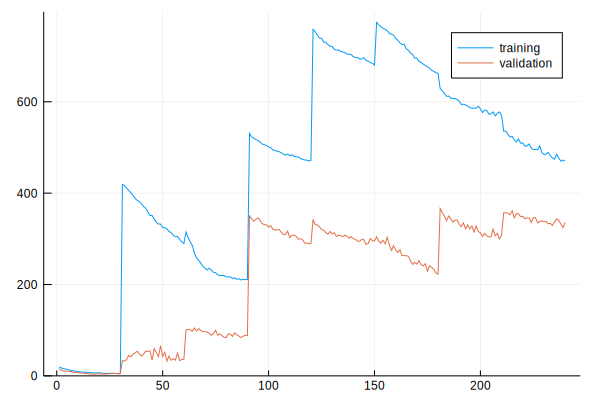

 22.961428 seconds (2.22 M allocations: 309.621 MiB, 2.55% gc time)


Progress:   8%|███                                      |  ETA: 10:28:33

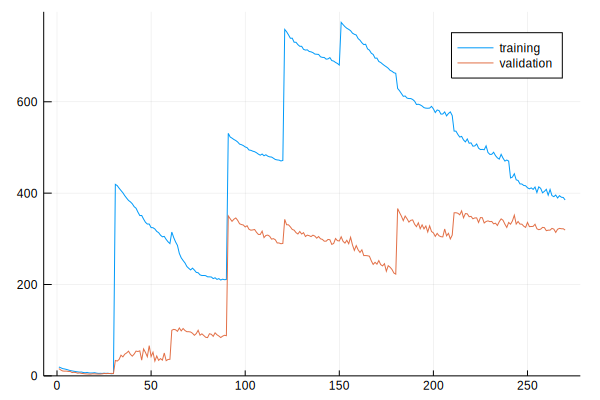

 42.647936 seconds (2.45 M allocations: 340.828 MiB, 0.46% gc time)


Progress:   9%|████                                     |  ETA: 10:38:45

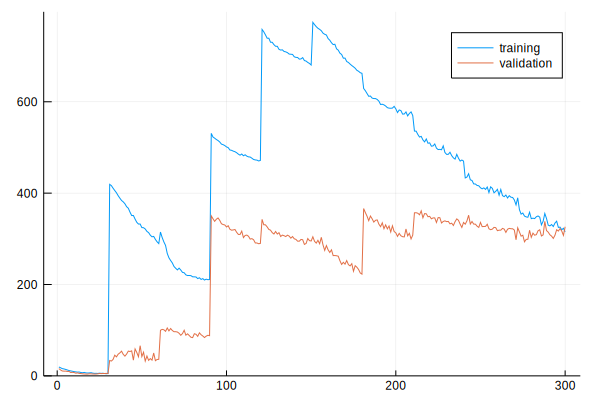

 42.360775 seconds (2.68 M allocations: 372.324 MiB, 0.69% gc time)


Progress:  10%|████                                     |  ETA: 10:41:52

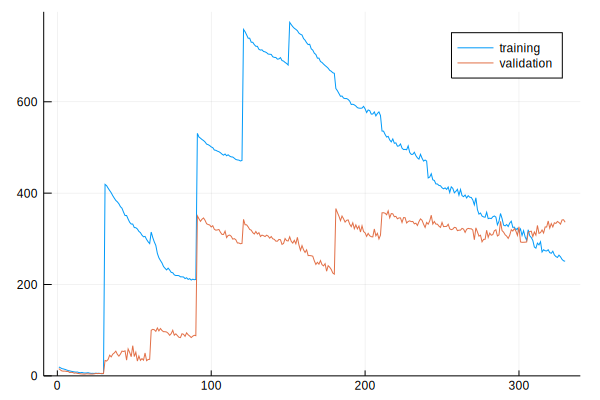

 22.331521 seconds (2.91 M allocations: 405.022 MiB, 1.06% gc time)


Progress:  11%|█████                                    |  ETA: 10:39:11

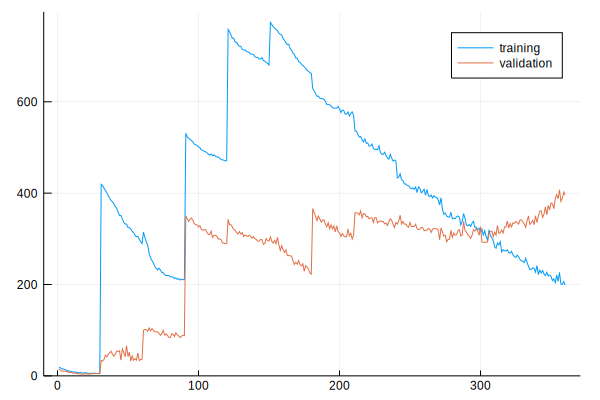

 90.116474 seconds (3.19 M allocations: 443.660 MiB, 0.45% gc time)


Progress:  12%|█████                                    |  ETA: 10:43:48

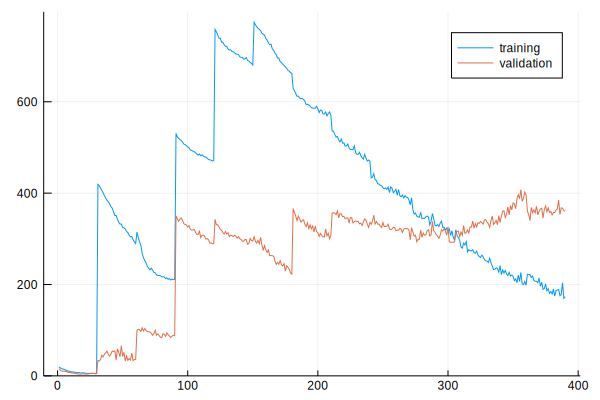

 15.091082 seconds (3.55 M allocations: 493.015 MiB, 1.39% gc time)


Progress:  13%|█████                                    |  ETA: 11:19:07

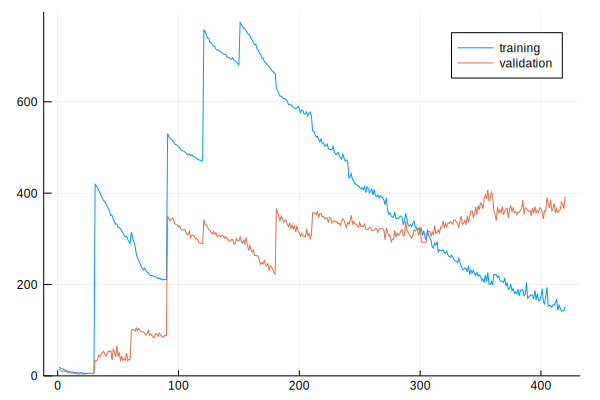

 18.598908 seconds (3.59 M allocations: 498.066 MiB, 1.14% gc time)


Progress:  14%|██████                                   |  ETA: 10:32:04

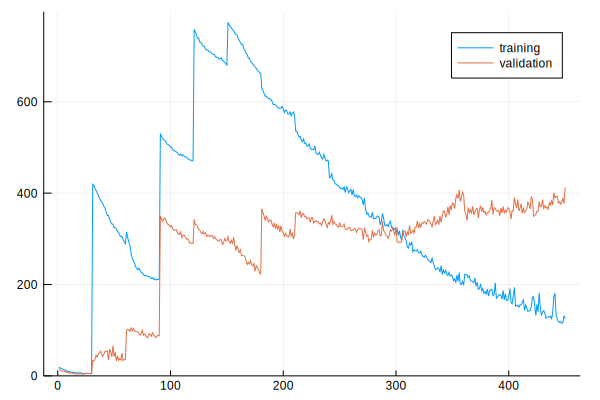

 14.623746 seconds (3.77 M allocations: 523.298 MiB, 1.59% gc time)


Progress:  15%|██████                                   |  ETA: 10:12:24

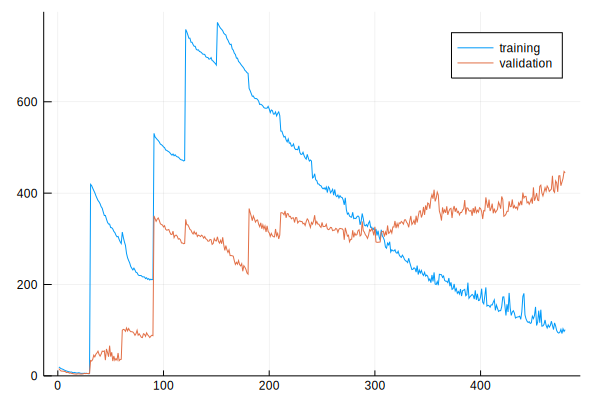

 16.050111 seconds (3.81 M allocations: 529.238 MiB, 1.37% gc time)


Progress:  16%|███████                                  |  ETA: 9:33:06

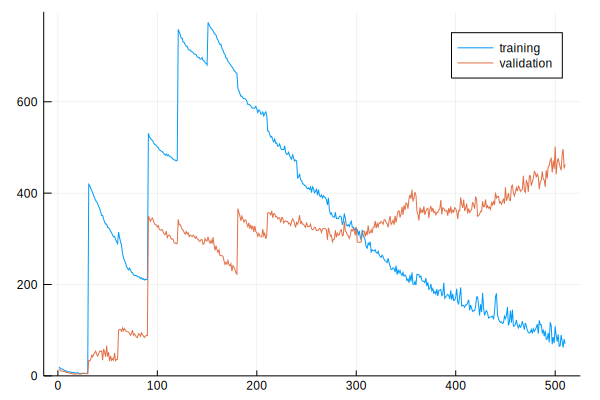

 15.049201 seconds (4.00 M allocations: 555.999 MiB, 1.41% gc time)


Progress:  17%|███████                                  |  ETA: 9:30:59

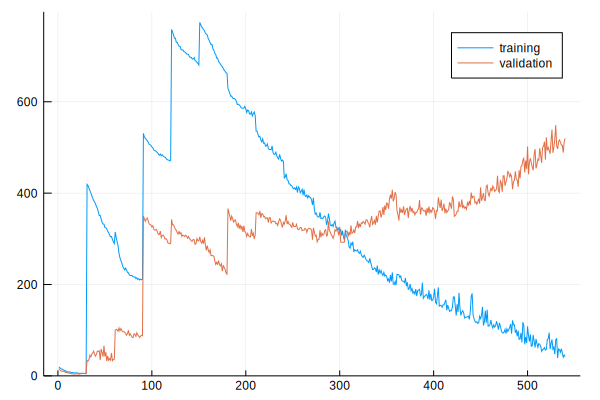

 22.002165 seconds (4.07 M allocations: 564.341 MiB, 1.29% gc time)


Progress:  18%|███████                                  |  ETA: 9:01:24

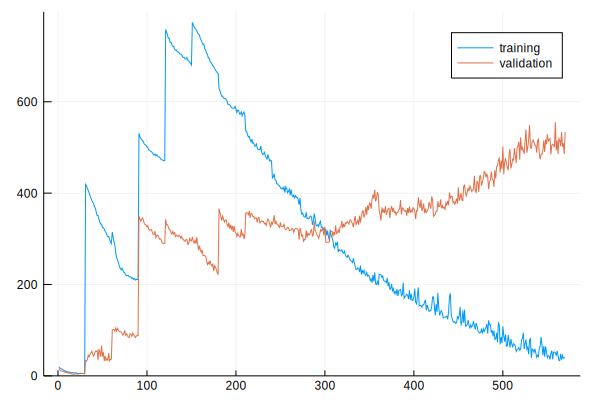

 17.725572 seconds (4.23 M allocations: 586.612 MiB, 1.39% gc time)


Progress:  19%|████████                                 |  ETA: 8:44:07

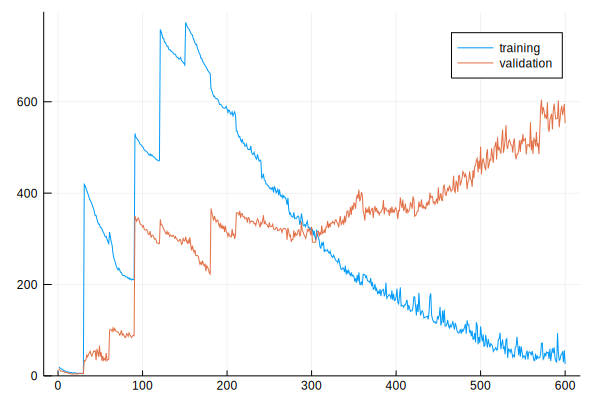

 19.016813 seconds (4.32 M allocations: 599.685 MiB, 1.32% gc time)


Progress:  20%|████████                                 |  ETA: 8:26:54

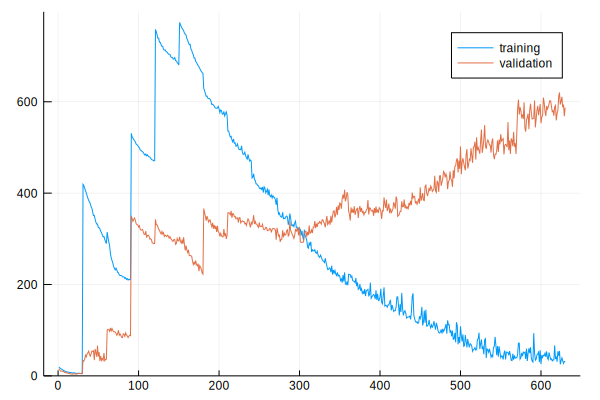

 18.712530 seconds (4.35 M allocations: 603.848 MiB, 1.46% gc time)


Progress:  21%|█████████                                |  ETA: 8:04:28

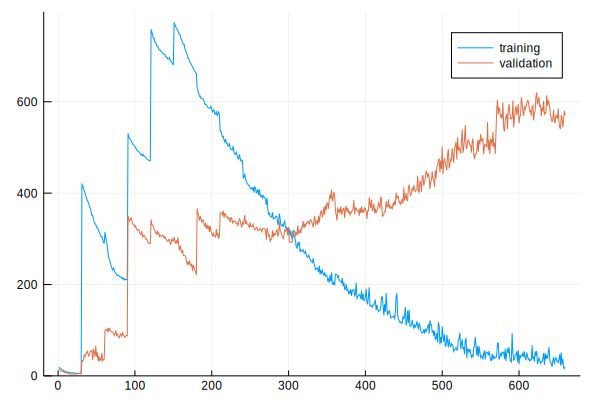

 23.248331 seconds (4.51 M allocations: 625.249 MiB, 1.07% gc time)


Progress:  22%|█████████                                |  ETA: 7:49:38

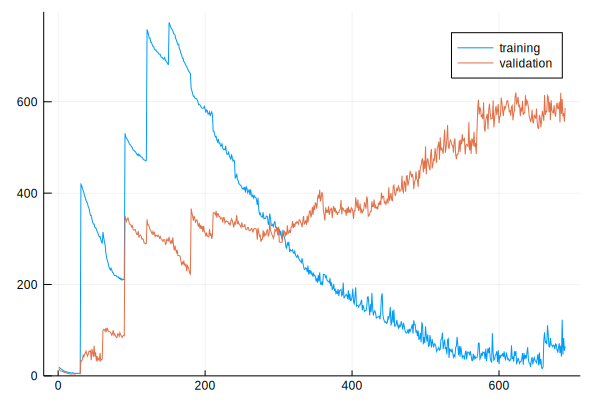

 17.611321 seconds (4.68 M allocations: 649.621 MiB, 1.82% gc time)


Progress:  23%|█████████                                |  ETA: 7:33:53

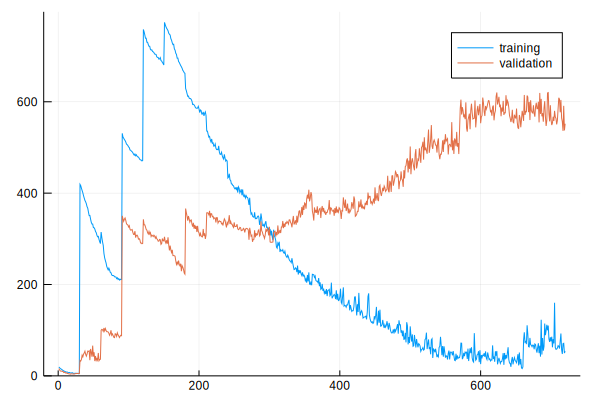

 31.245790 seconds (4.84 M allocations: 671.326 MiB, 1.02% gc time)


Progress:  24%|██████████                               |  ETA: 7:18:45

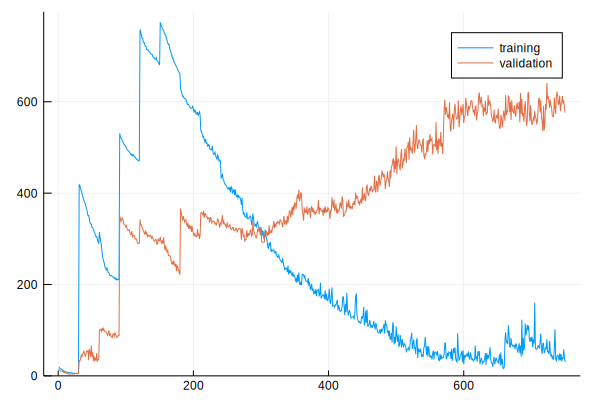

 17.282111 seconds (4.94 M allocations: 685.567 MiB, 1.61% gc time)


Progress:  25%|██████████                               |  ETA: 7:07:05

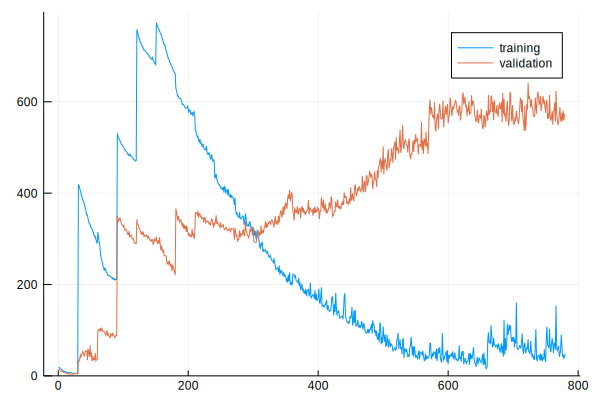

 18.283272 seconds (5.17 M allocations: 716.792 MiB, 1.59% gc time)


Progress:  26%|███████████                              |  ETA: 6:59:10

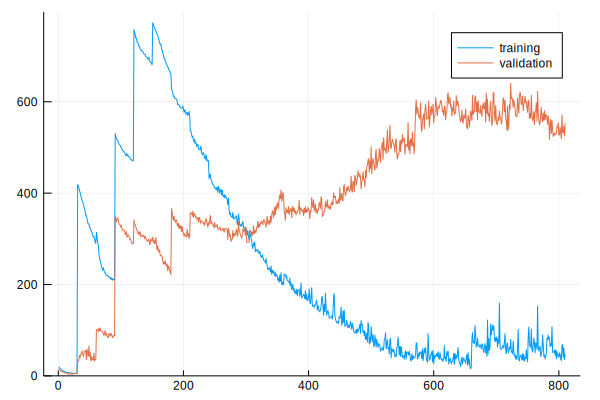

 24.675319 seconds (5.42 M allocations: 751.572 MiB, 1.29% gc time)


Progress:  27%|███████████                              |  ETA: 6:58:43

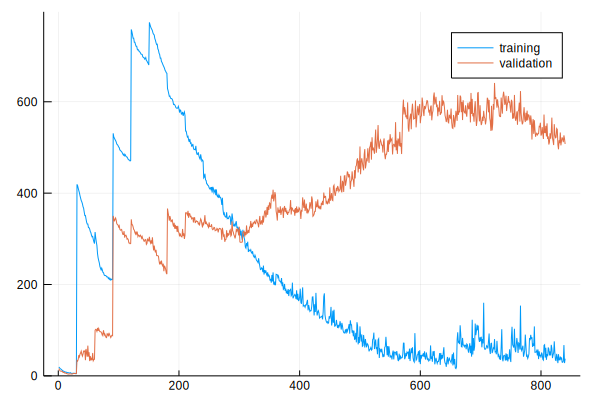

 20.494229 seconds (5.62 M allocations: 778.328 MiB, 1.62% gc time)


Progress:  28%|███████████                              |  ETA: 6:54:55

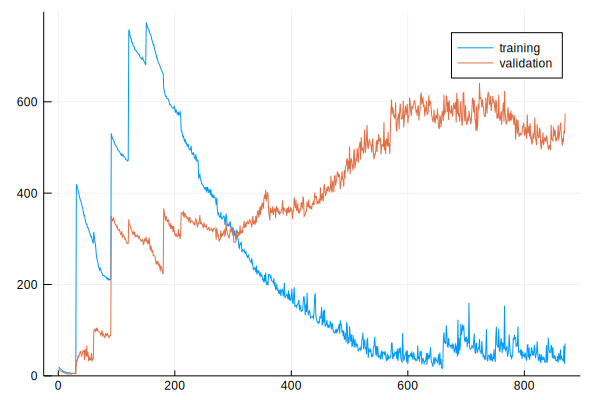

 34.045719 seconds (5.79 M allocations: 802.116 MiB, 0.93% gc time)


Progress:  29%|████████████                             |  ETA: 6:45:12

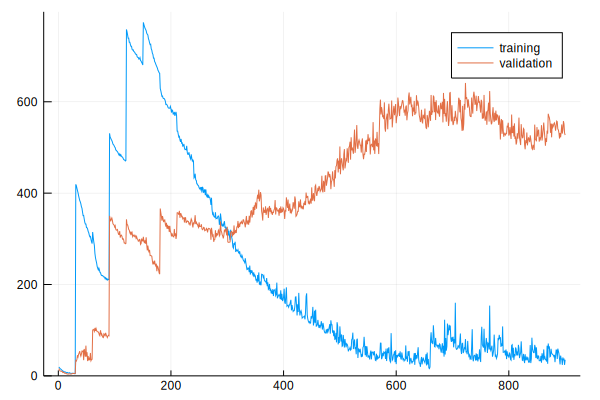

 32.225136 seconds (5.88 M allocations: 813.996 MiB, 1.19% gc time)


Progress:  30%|████████████                             |  ETA: 6:32:36

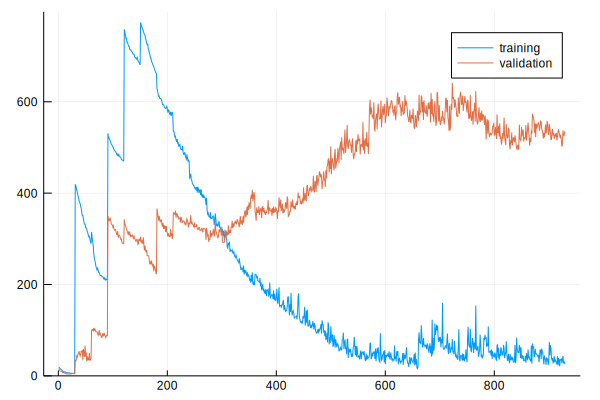

 29.121114 seconds (5.97 M allocations: 827.071 MiB, 1.41% gc time)


Progress:  31%|█████████████                            |  ETA: 6:20:46

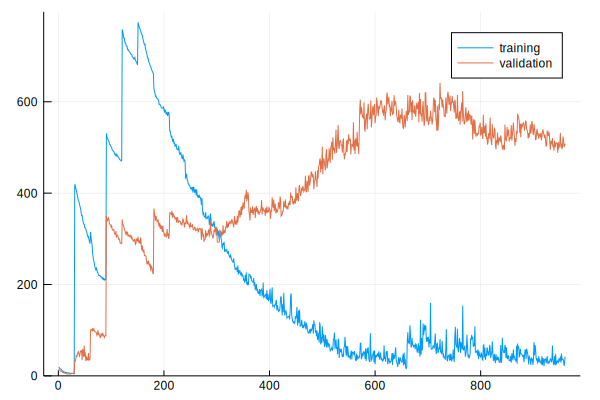

 29.695711 seconds (6.05 M allocations: 838.369 MiB, 1.27% gc time)


Progress:  32%|█████████████                            |  ETA: 6:09:33

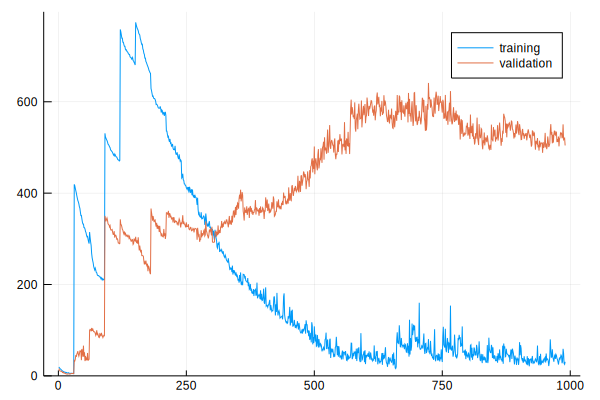

 26.372768 seconds (6.32 M allocations: 875.787 MiB, 1.35% gc time)


Progress:  33%|██████████████                           |  ETA: 6:06:37

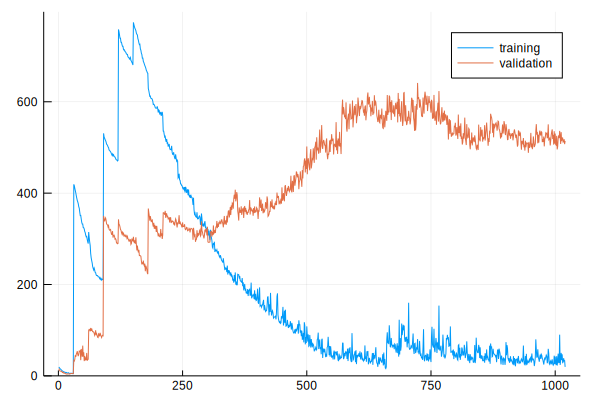

 34.485631 seconds (6.45 M allocations: 894.218 MiB, 1.15% gc time)


Progress:  34%|██████████████                           |  ETA: 5:56:38

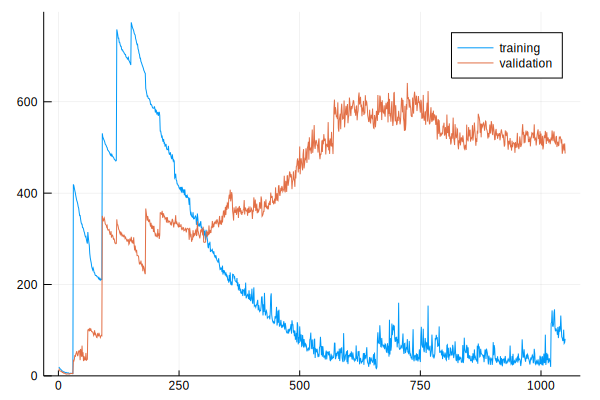

 33.811742 seconds (6.61 M allocations: 915.954 MiB, 1.25% gc time)


Progress:  35%|██████████████                           |  ETA: 5:46:56

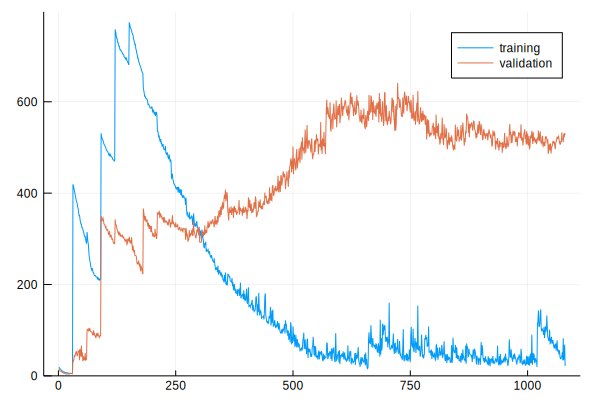

 34.846002 seconds (6.67 M allocations: 923.641 MiB, 1.17% gc time)


Progress:  36%|███████████████                          |  ETA: 5:37:06

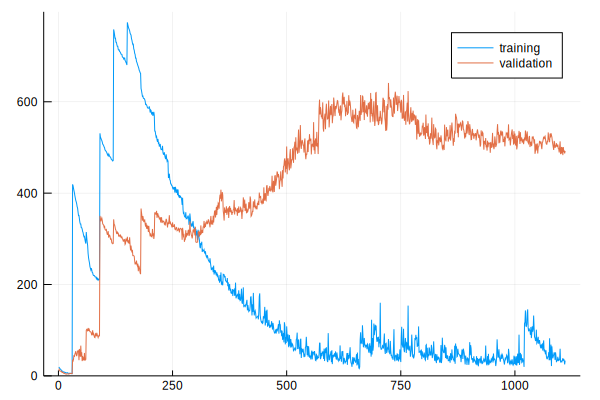

 35.260719 seconds (6.91 M allocations: 958.114 MiB, 1.26% gc time)


Progress:  37%|███████████████                          |  ETA: 5:34:11

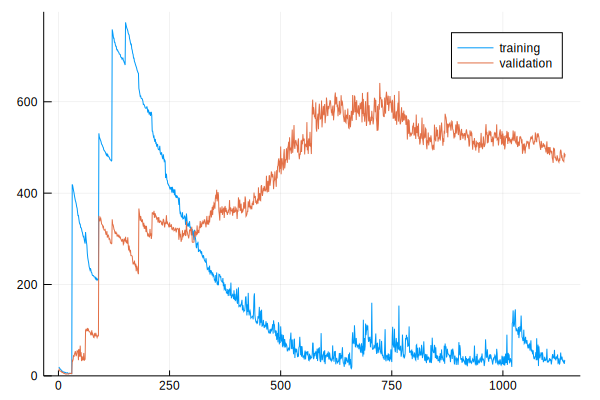

 41.720376 seconds (7.16 M allocations: 991.701 MiB, 1.16% gc time)


Progress:  38%|████████████████                         |  ETA: 5:28:58

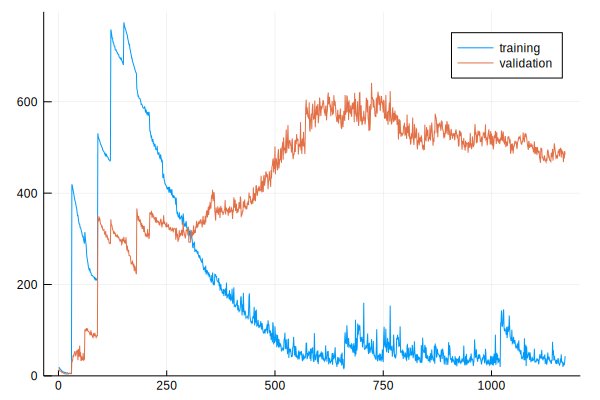

 48.703882 seconds (7.35 M allocations: 1019.017 MiB, 0.87% gc time)


Progress:  39%|████████████████                         |  ETA: 5:26:40

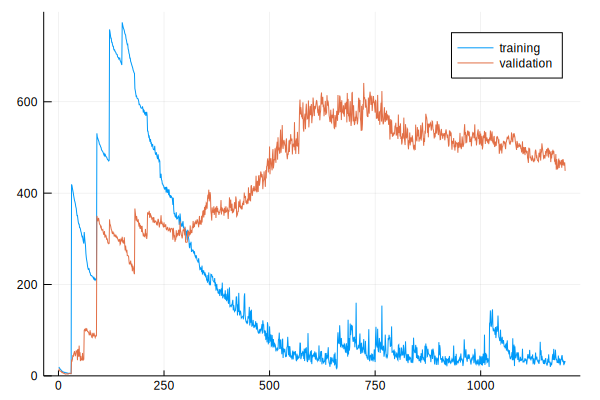

 42.468495 seconds (7.60 M allocations: 1.029 GiB, 1.42% gc time)


Progress:  40%|████████████████                         |  ETA: 5:22:38

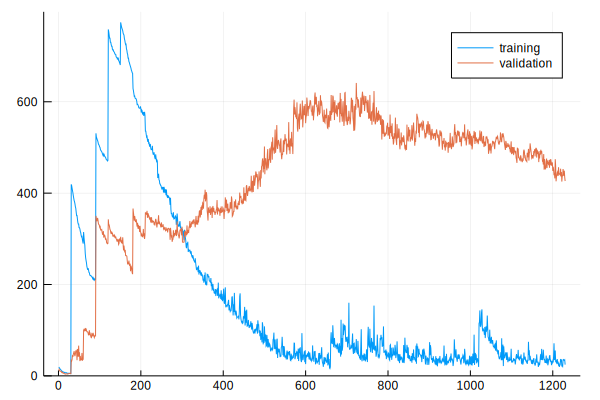

 44.500854 seconds (7.79 M allocations: 1.055 GiB, 0.96% gc time)


Progress:  41%|█████████████████                        |  ETA: 5:18:05

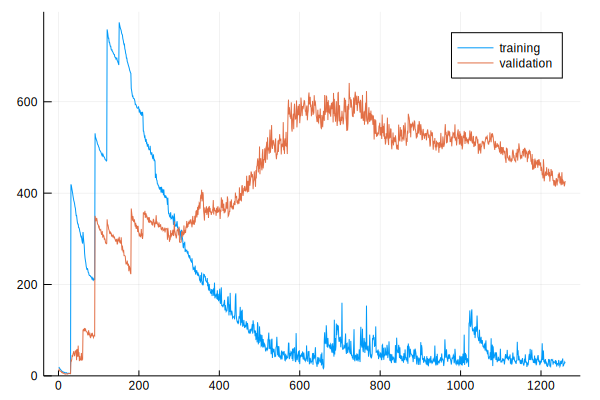

 69.861155 seconds (7.93 M allocations: 1.073 GiB, 0.95% gc time)


Progress:  42%|█████████████████                        |  ETA: 5:10:38

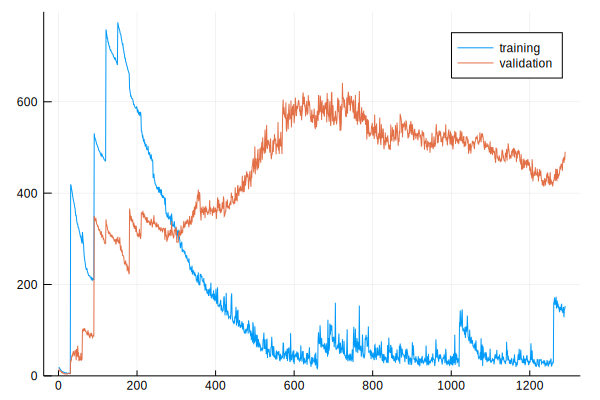

 41.391317 seconds (8.12 M allocations: 1.099 GiB, 1.35% gc time)


Progress:  43%|██████████████████                       |  ETA: 5:06:38

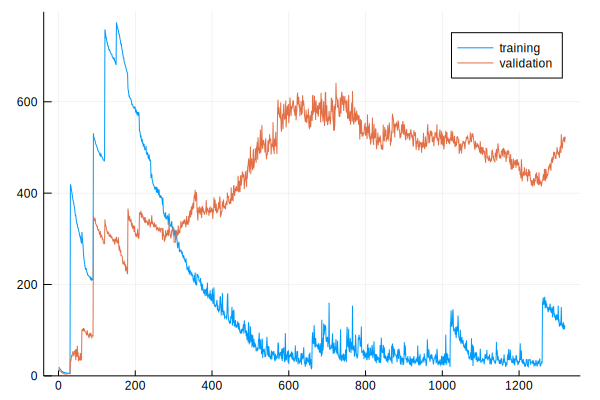

 36.477767 seconds (8.35 M allocations: 1.130 GiB, 1.53% gc time)


Progress:  44%|██████████████████                       |  ETA: 5:01:27

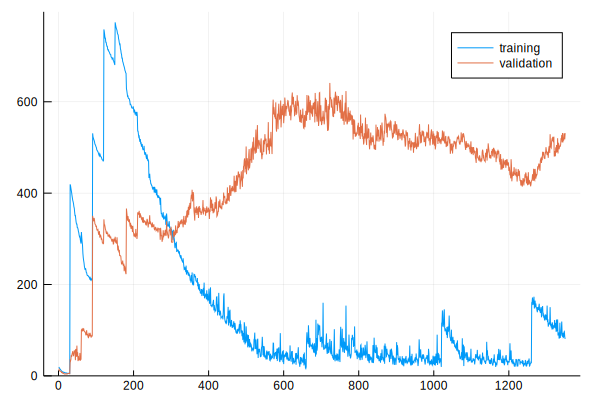

 29.712858 seconds (8.67 M allocations: 1.174 GiB, 1.78% gc time)


Progress:  45%|██████████████████                       |  ETA: 4:58:40

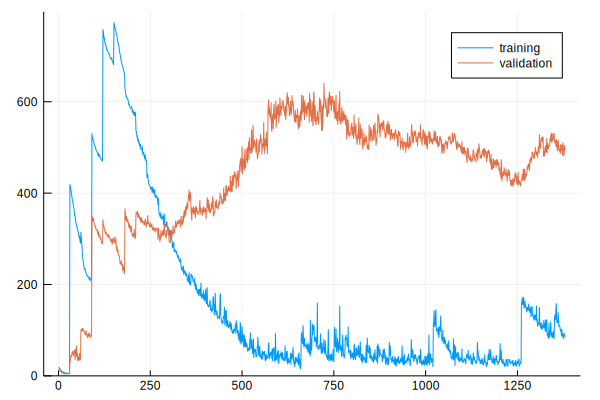

 48.306463 seconds (8.79 M allocations: 1.190 GiB, 1.19% gc time)


Progress:  46%|███████████████████                      |  ETA: 4:52:40

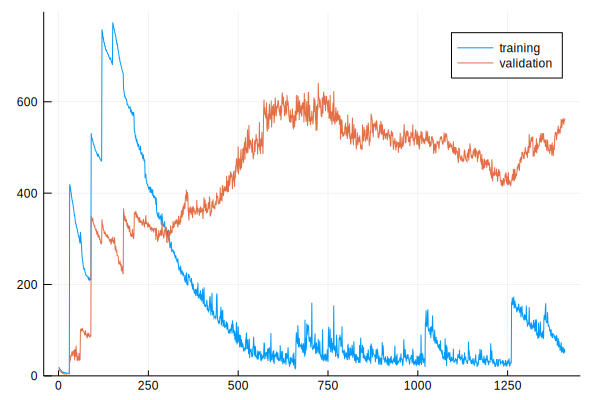

 48.640392 seconds (9.09 M allocations: 1.232 GiB, 1.80% gc time)


Progress:  47%|███████████████████                      |  ETA: 4:50:09

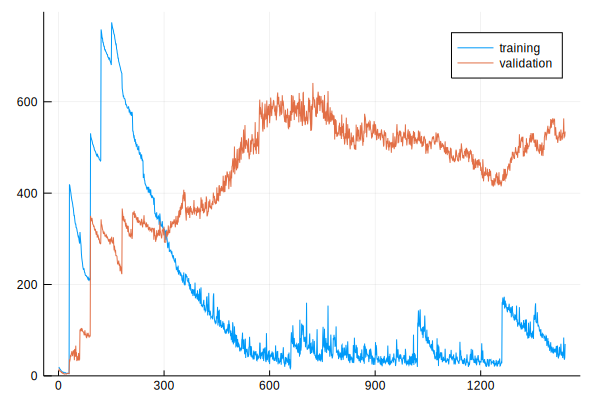

 48.005140 seconds (9.32 M allocations: 1.263 GiB, 1.21% gc time)


Progress:  48%|████████████████████                     |  ETA: 4:46:29

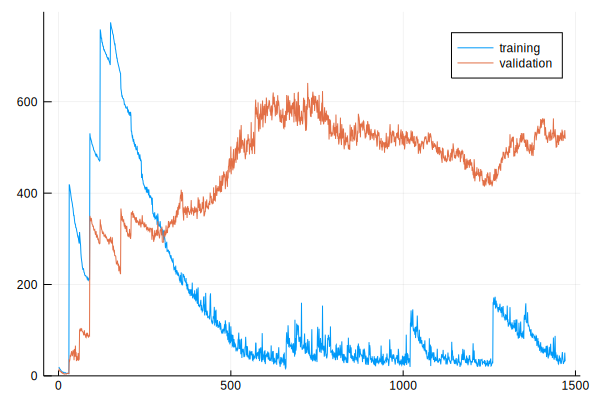

 50.546551 seconds (9.50 M allocations: 1.288 GiB, 1.23% gc time)


Progress:  49%|████████████████████                     |  ETA: 4:40:49

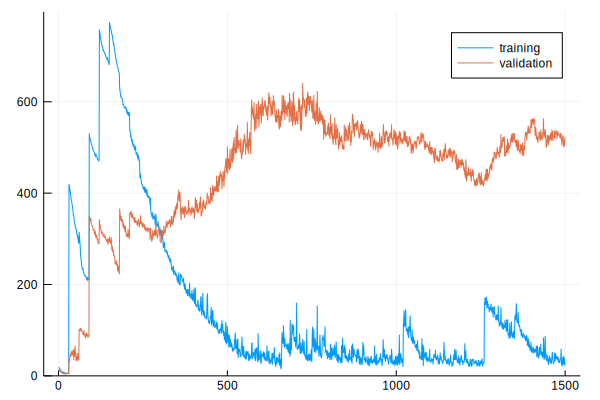

 52.052926 seconds (9.81 M allocations: 1.329 GiB, 1.04% gc time)


Progress:  50%|████████████████████                     |  ETA: 4:38:18

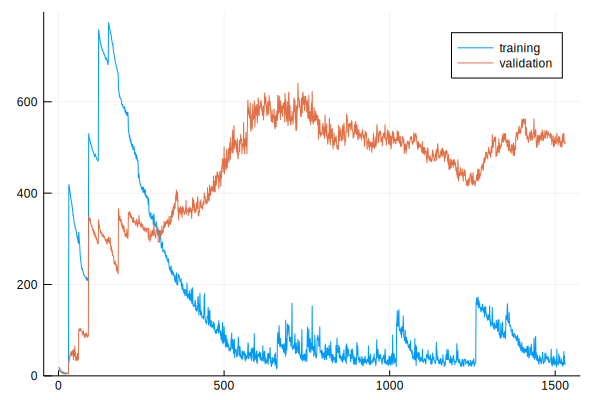

 53.103951 seconds (9.85 M allocations: 1.335 GiB, 1.17% gc time)


Progress:  51%|█████████████████████                    |  ETA: 4:29:21

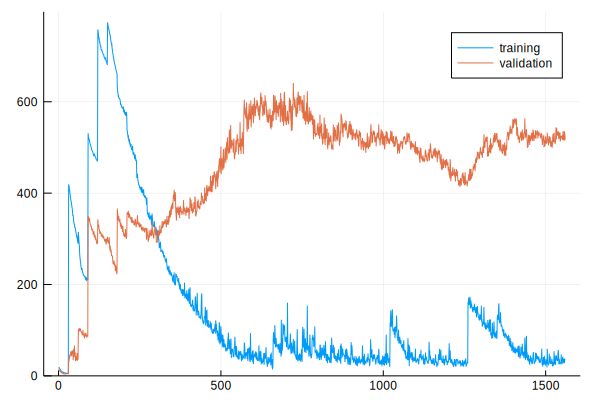

 53.843909 seconds (10.06 M allocations: 1.363 GiB, 1.69% gc time)


Progress:  52%|█████████████████████                    |  ETA: 4:24:02

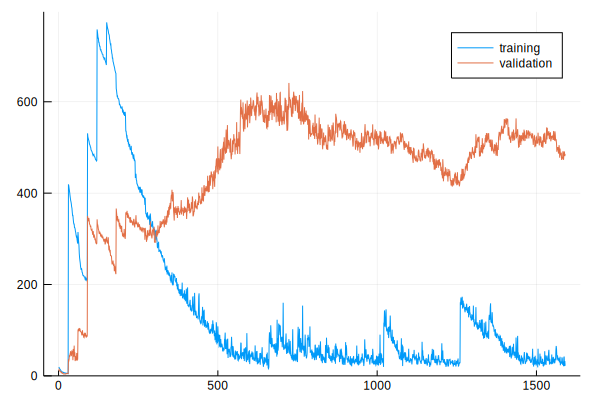

 56.505401 seconds (10.23 M allocations: 1.386 GiB, 1.22% gc time)


Progress:  53%|██████████████████████                   |  ETA: 4:17:13

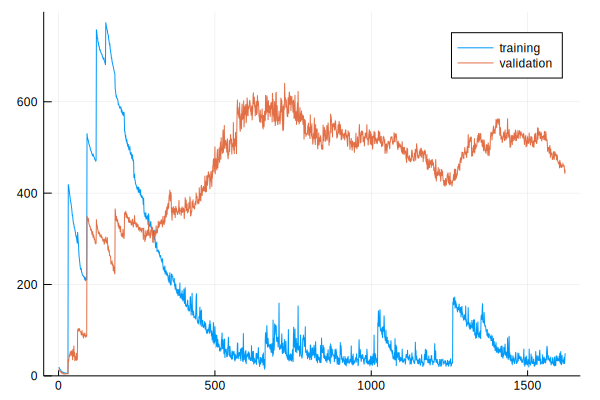

 50.944029 seconds (10.50 M allocations: 1.422 GiB, 1.45% gc time)


Progress:  54%|██████████████████████                   |  ETA: 4:12:26

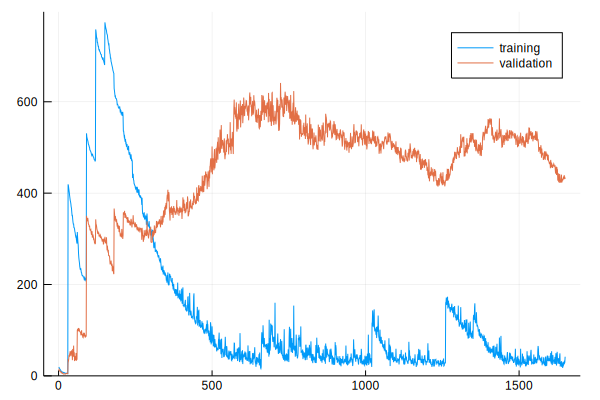

 44.739860 seconds (10.67 M allocations: 1.444 GiB, 1.32% gc time)


Progress:  55%|███████████████████████                  |  ETA: 4:06:30

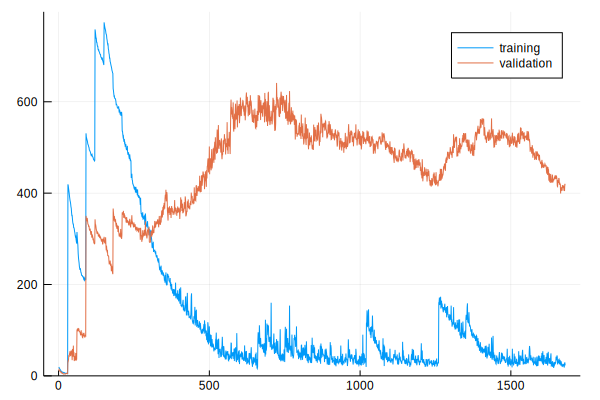

 57.554115 seconds (10.93 M allocations: 1.480 GiB, 1.18% gc time)


Progress:  56%|███████████████████████                  |  ETA: 4:01:45

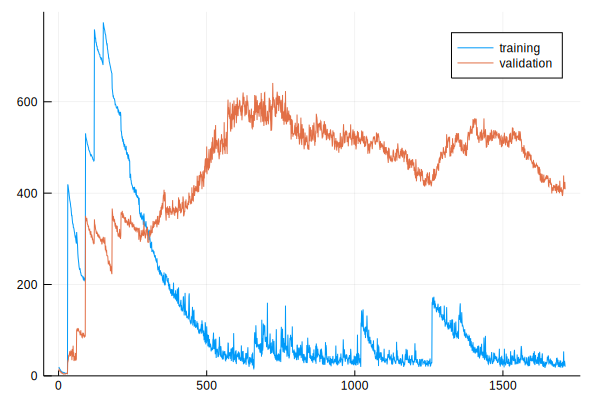

 60.148785 seconds (11.48 M allocations: 1.553 GiB, 1.06% gc time)


Progress:  57%|███████████████████████                  |  ETA: 3:59:29

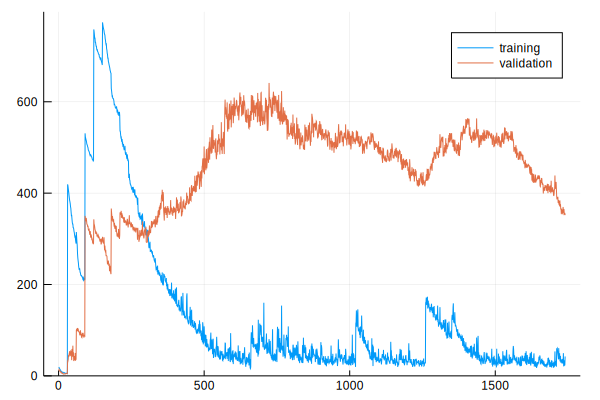

 73.703132 seconds (11.75 M allocations: 1.589 GiB, 0.94% gc time)


Progress:  58%|████████████████████████                 |  ETA: 3:56:06

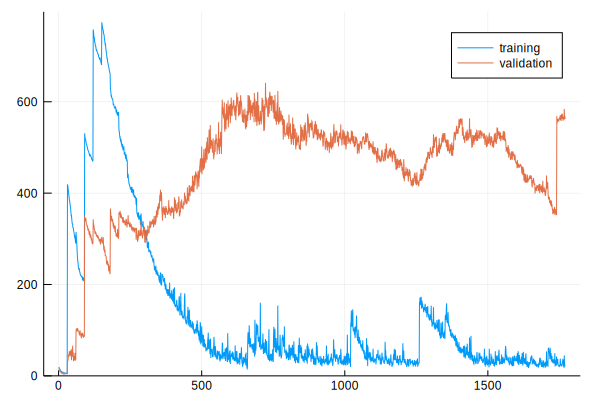

 62.338619 seconds (11.90 M allocations: 1.611 GiB, 1.24% gc time)


Progress:  59%|████████████████████████                 |  ETA: 3:50:27

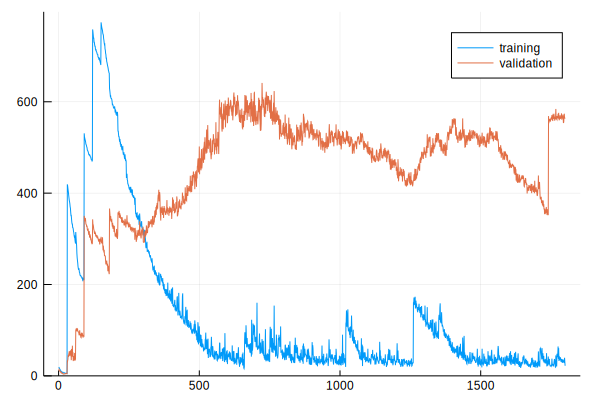

 63.666809 seconds (12.14 M allocations: 1.642 GiB, 1.02% gc time)


Progress:  60%|█████████████████████████                |  ETA: 3:45:01

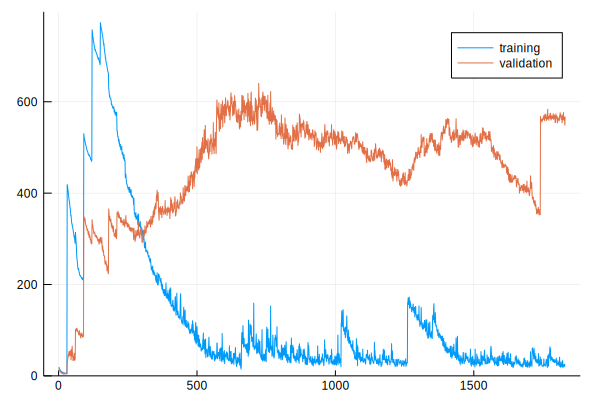

 66.892135 seconds (12.17 M allocations: 1.646 GiB, 1.00% gc time)


Progress:  61%|█████████████████████████                |  ETA: 3:38:13

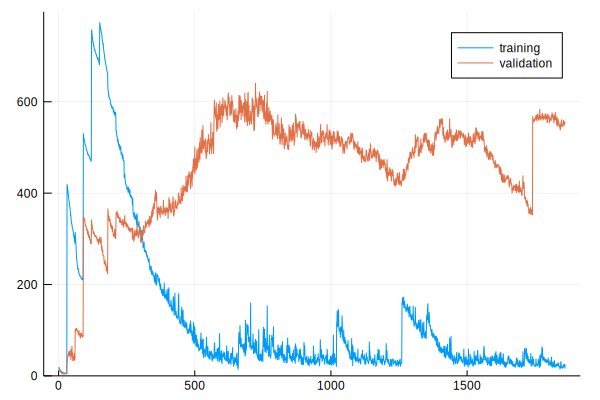

 74.400297 seconds (12.24 M allocations: 1.655 GiB, 0.94% gc time)


Progress:  62%|█████████████████████████                |  ETA: 3:33:10

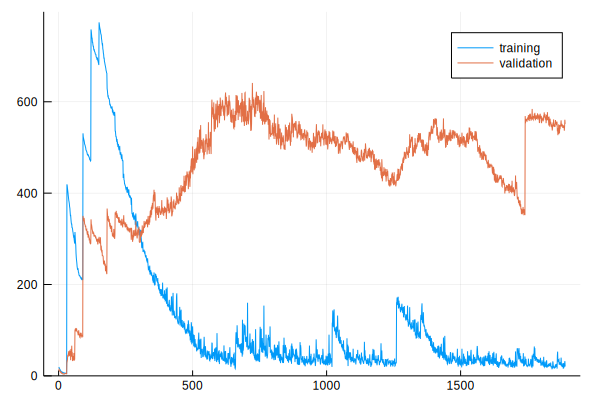

 84.540906 seconds (12.57 M allocations: 1.701 GiB, 0.91% gc time)


Progress:  63%|██████████████████████████               |  ETA: 3:29:58

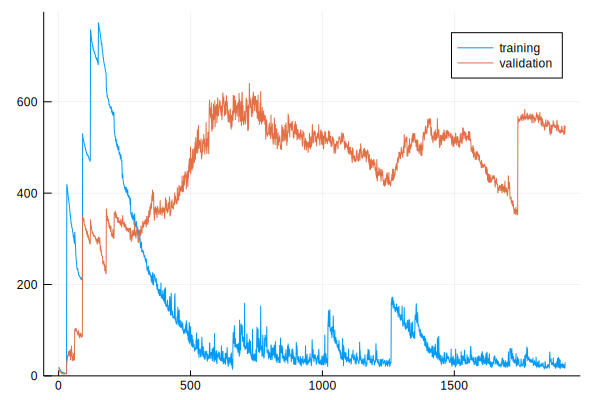

 44.660442 seconds (12.76 M allocations: 1.727 GiB, 1.78% gc time)


Progress:  64%|██████████████████████████               |  ETA: 3:23:31

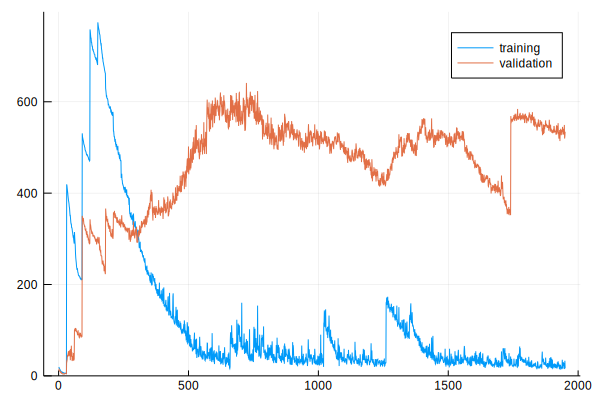

 65.134677 seconds (12.88 M allocations: 1.744 GiB, 1.12% gc time)


Progress:  65%|███████████████████████████              |  ETA: 3:16:50

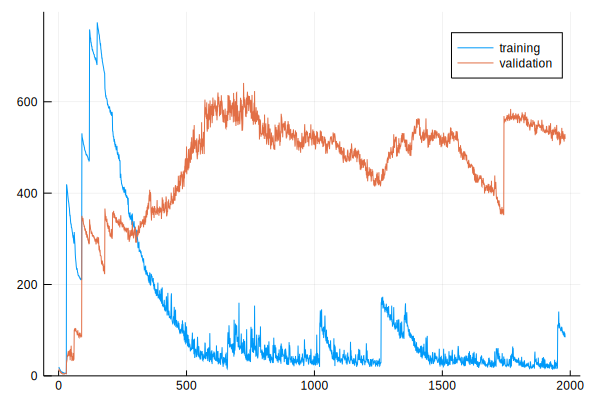

 71.912731 seconds (12.97 M allocations: 1.756 GiB, 0.99% gc time)


Progress:  66%|███████████████████████████              |  ETA: 3:09:59

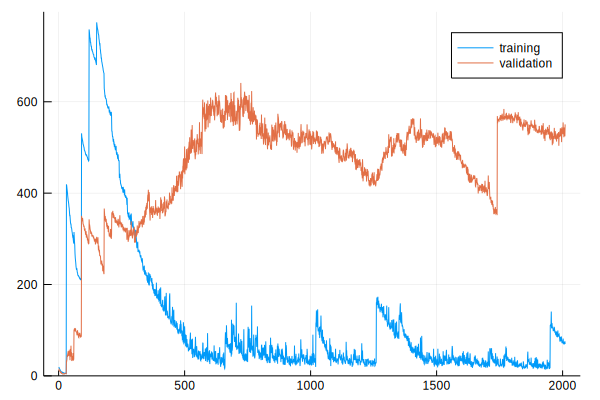

 76.609976 seconds (13.04 M allocations: 1.765 GiB, 1.12% gc time)


Progress:  67%|███████████████████████████              |  ETA: 3:03:03

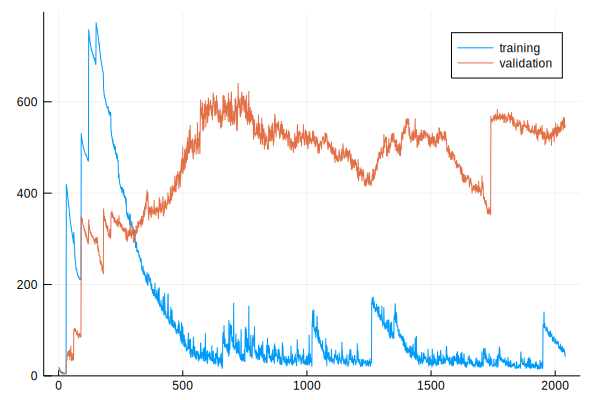

 73.855283 seconds (13.23 M allocations: 1.791 GiB, 1.09% gc time)


Progress:  68%|████████████████████████████             |  ETA: 2:57:26

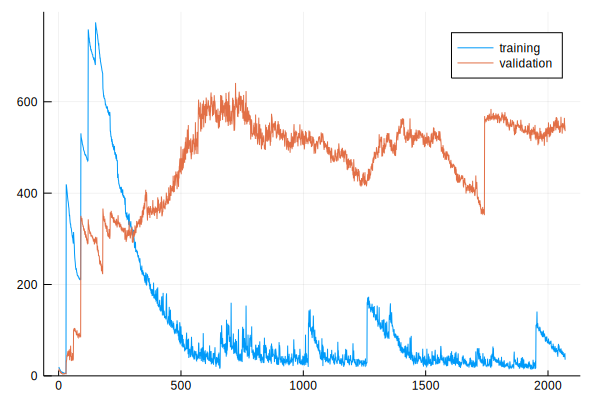

 56.912511 seconds (13.40 M allocations: 1.814 GiB, 1.36% gc time)


Progress:  69%|████████████████████████████             |  ETA: 2:51:33

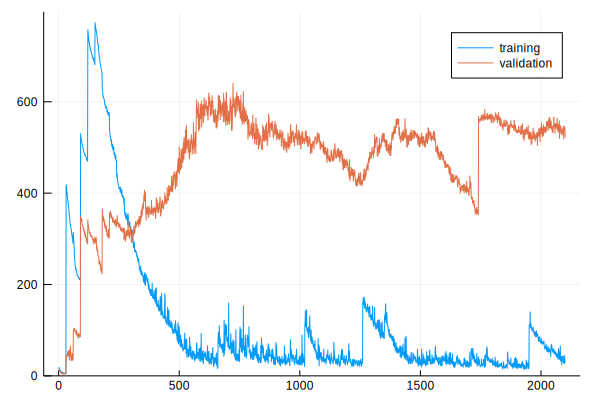

 58.788488 seconds (13.64 M allocations: 1.847 GiB, 1.27% gc time)


Progress:  70%|█████████████████████████████            |  ETA: 2:47:11

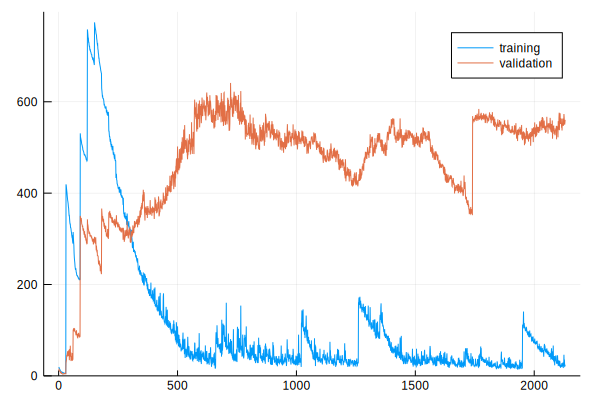

 63.479482 seconds (13.76 M allocations: 1.863 GiB, 1.07% gc time)


Progress:  71%|█████████████████████████████            |  ETA: 2:41:06

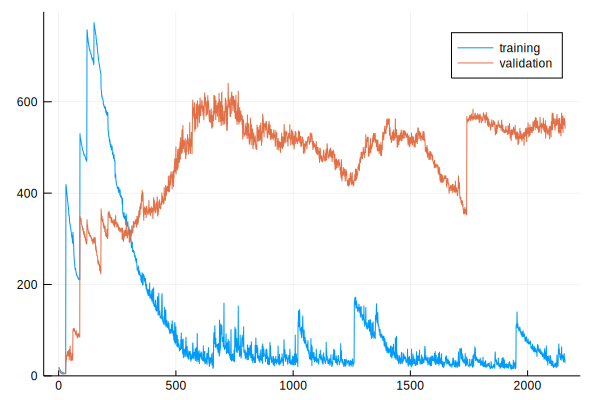

 65.215400 seconds (14.00 M allocations: 1.895 GiB, 1.49% gc time)


Progress:  72%|██████████████████████████████           |  ETA: 2:36:12

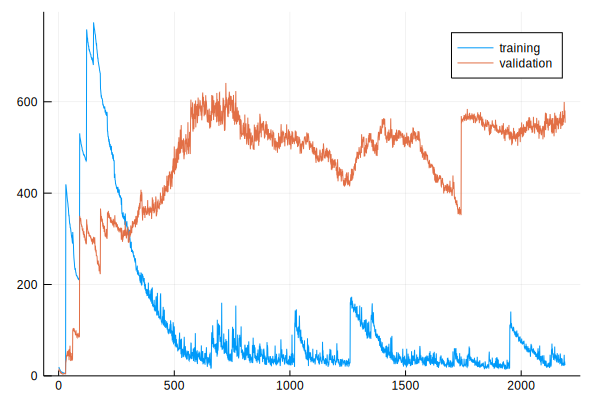

 63.898932 seconds (14.13 M allocations: 1.913 GiB, 1.17% gc time)


Progress:  73%|██████████████████████████████           |  ETA: 2:30:06

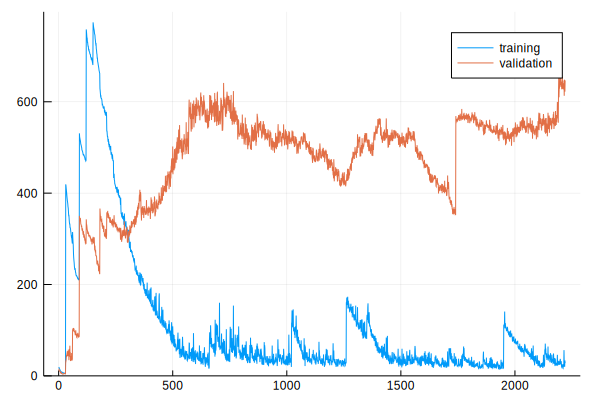

 57.194340 seconds (14.41 M allocations: 1.951 GiB, 1.48% gc time)


Progress:  74%|██████████████████████████████           |  ETA: 2:24:54

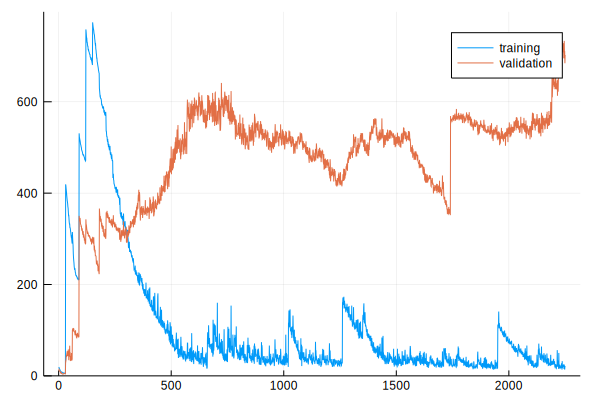

 86.021562 seconds (14.50 M allocations: 1.964 GiB, 1.01% gc time)


Progress:  75%|███████████████████████████████          |  ETA: 2:19:06

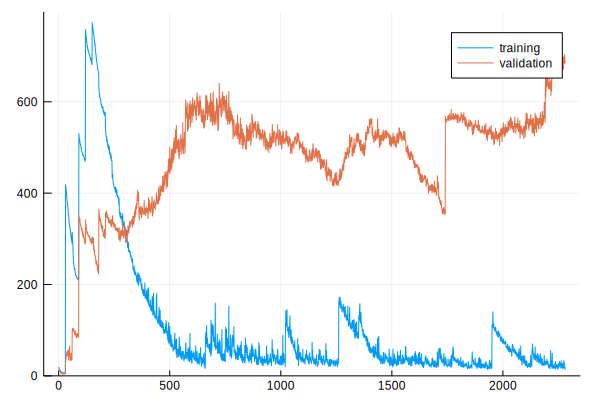

 55.858864 seconds (14.63 M allocations: 1.981 GiB, 1.57% gc time)


Progress:  76%|███████████████████████████████          |  ETA: 2:12:48

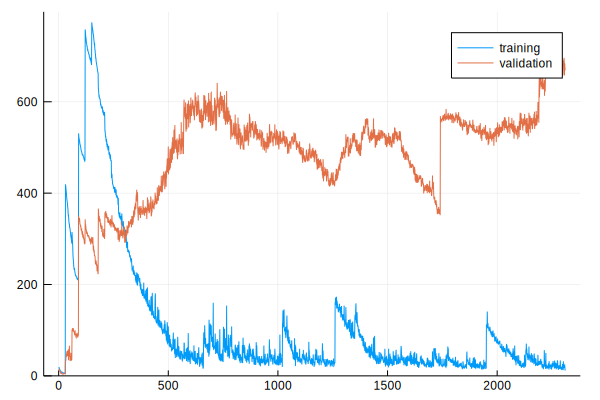

 73.643413 seconds (14.79 M allocations: 2.003 GiB, 1.22% gc time)


Progress:  77%|████████████████████████████████         |  ETA: 2:07:16

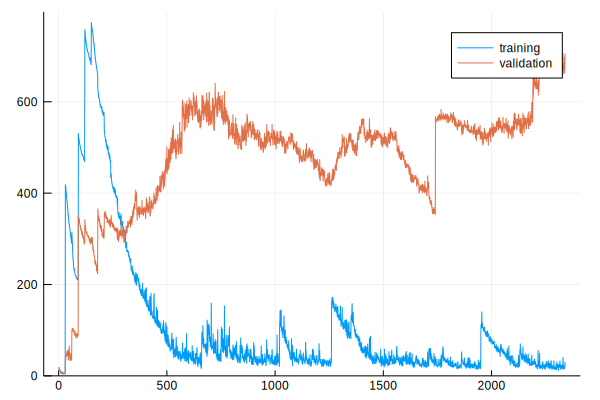

 73.587261 seconds (14.93 M allocations: 2.022 GiB, 1.18% gc time)


Progress:  78%|████████████████████████████████         |  ETA: 2:01:50

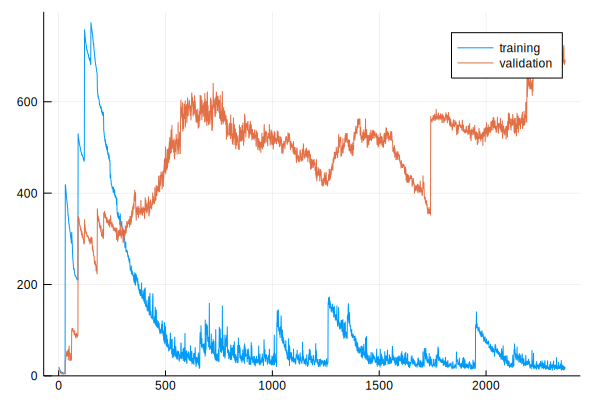

 52.008188 seconds (15.17 M allocations: 2.054 GiB, 1.69% gc time)


Progress:  79%|████████████████████████████████         |  ETA: 1:56:12

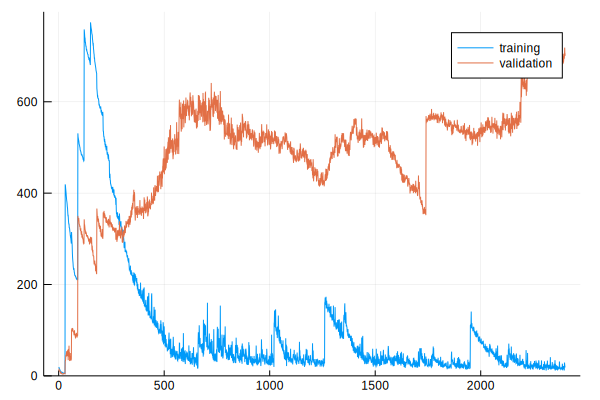

 71.216752 seconds (15.26 M allocations: 2.067 GiB, 1.24% gc time)


Progress:  80%|█████████████████████████████████        |  ETA: 1:50:27

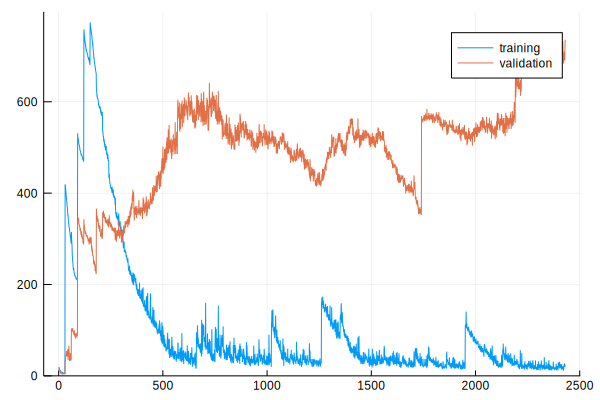

 65.635835 seconds (15.50 M allocations: 2.099 GiB, 1.36% gc time)


Progress:  81%|█████████████████████████████████        |  ETA: 1:45:01

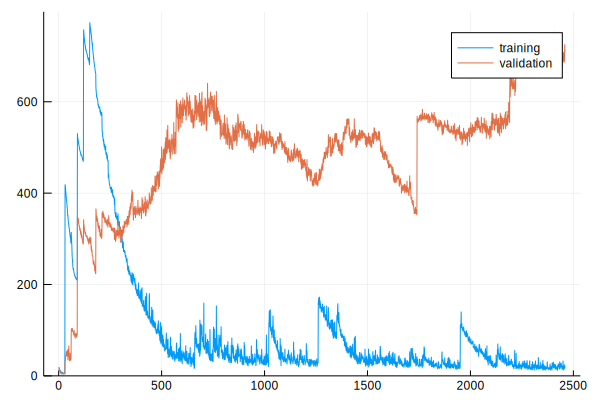

 71.748687 seconds (15.80 M allocations: 2.138 GiB, 1.27% gc time)


Progress:  82%|██████████████████████████████████       |  ETA: 1:39:47

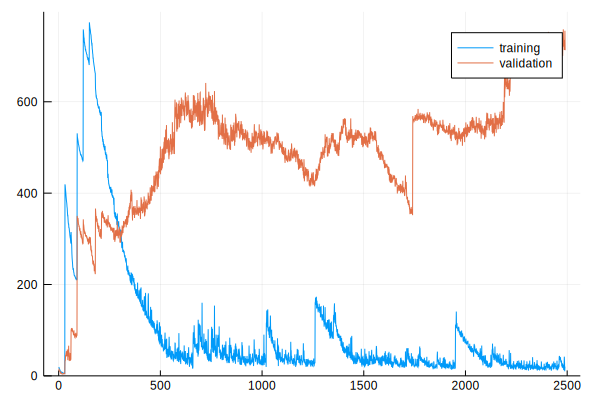

 65.151486 seconds (15.95 M allocations: 2.159 GiB, 1.48% gc time)


Progress:  83%|██████████████████████████████████       |  ETA: 1:34:05

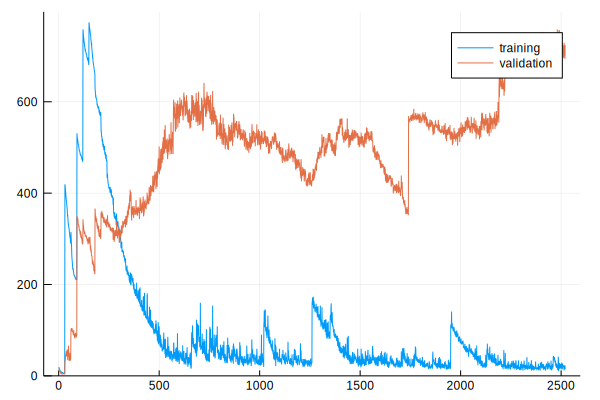

 74.500955 seconds (16.49 M allocations: 2.232 GiB, 1.36% gc time)


Progress:  84%|██████████████████████████████████       |  ETA: 1:29:33

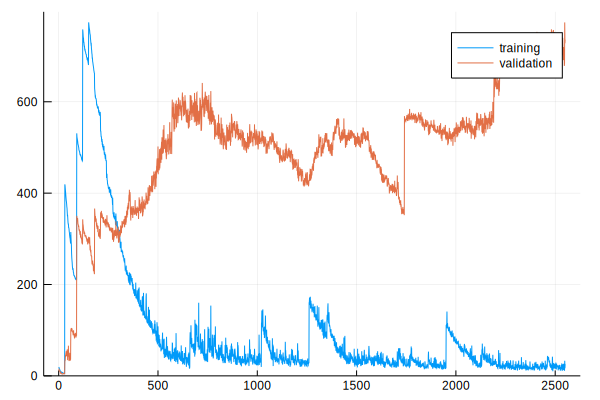

 80.469656 seconds (16.62 M allocations: 2.249 GiB, 1.17% gc time)


Progress:  85%|███████████████████████████████████      |  ETA: 1:23:49

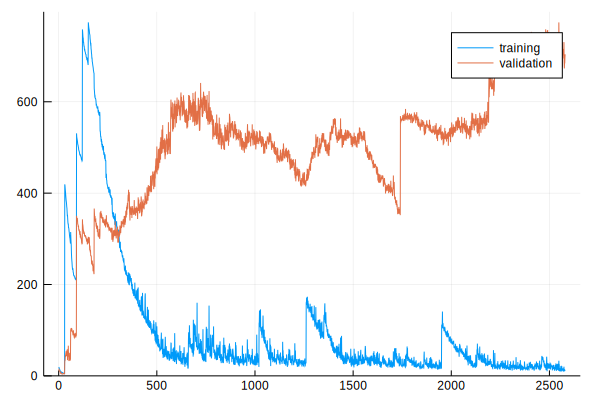

 75.518134 seconds (16.72 M allocations: 2.264 GiB, 1.16% gc time)


Progress:  86%|███████████████████████████████████      |  ETA: 1:18:06

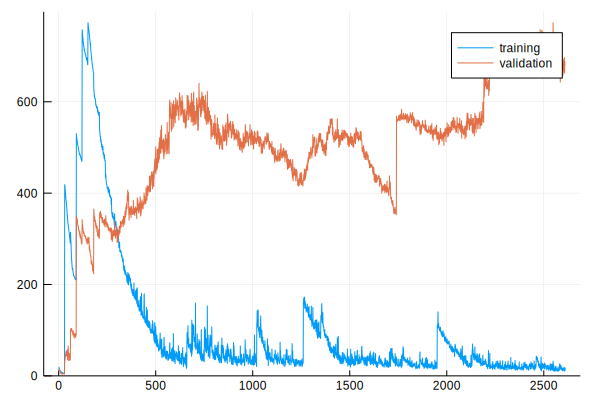

 77.642890 seconds (17.36 M allocations: 2.349 GiB, 1.44% gc time)


Progress:  87%|████████████████████████████████████     |  ETA: 1:13:32

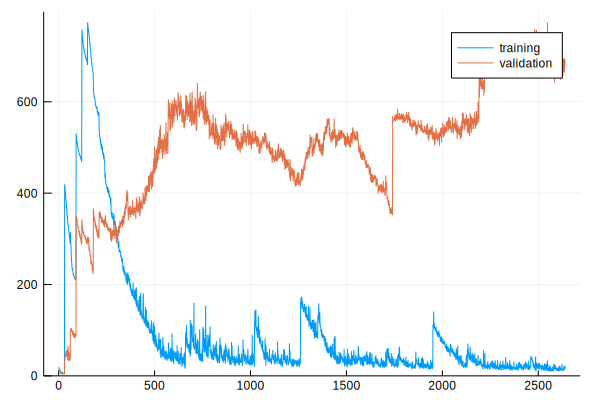

 98.915653 seconds (17.53 M allocations: 2.372 GiB, 1.09% gc time)


Progress:  88%|████████████████████████████████████     |  ETA: 1:07:44

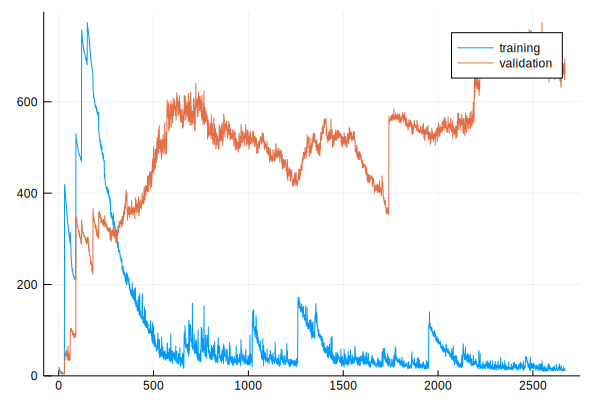

101.796583 seconds (17.84 M allocations: 2.415 GiB, 0.97% gc time)


Progress:  89%|████████████████████████████████████     |  ETA: 1:02:38

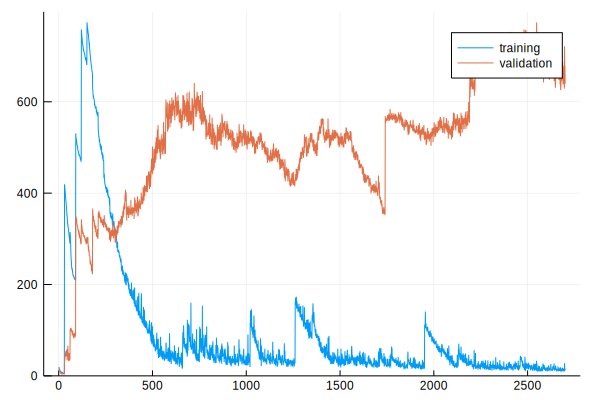

 79.830532 seconds (17.91 M allocations: 2.424 GiB, 1.30% gc time)


Progress:  90%|█████████████████████████████████████    |  ETA: 0:56:38

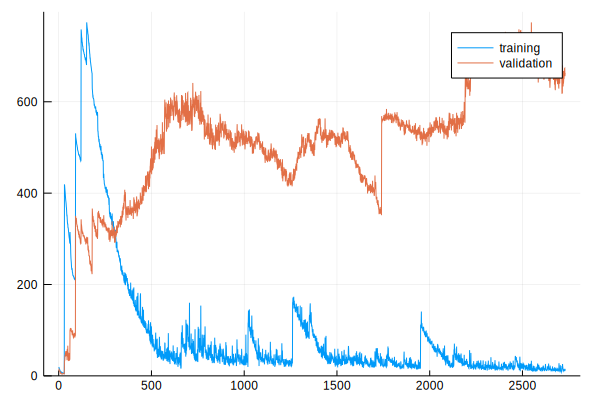

 83.488162 seconds (18.11 M allocations: 2.451 GiB, 1.21% gc time)


Progress:  91%|█████████████████████████████████████    |  ETA: 0:51:02

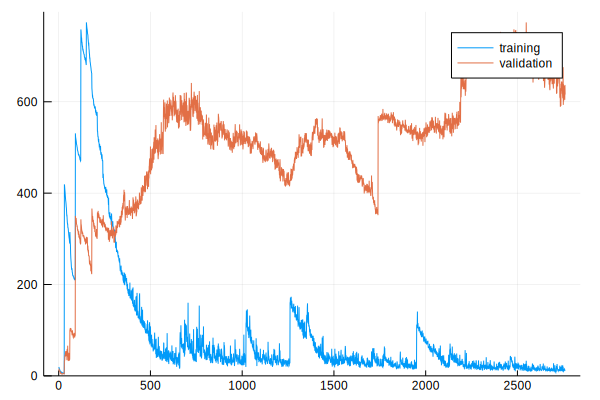

 97.157278 seconds (18.34 M allocations: 2.482 GiB, 1.13% gc time)


Progress:  92%|██████████████████████████████████████   |  ETA: 0:45:23

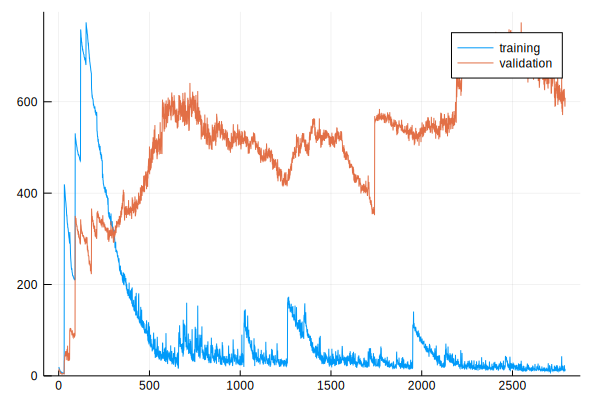

 99.858227 seconds (18.47 M allocations: 2.499 GiB, 1.28% gc time)


Progress:  93%|██████████████████████████████████████   |  ETA: 0:39:40

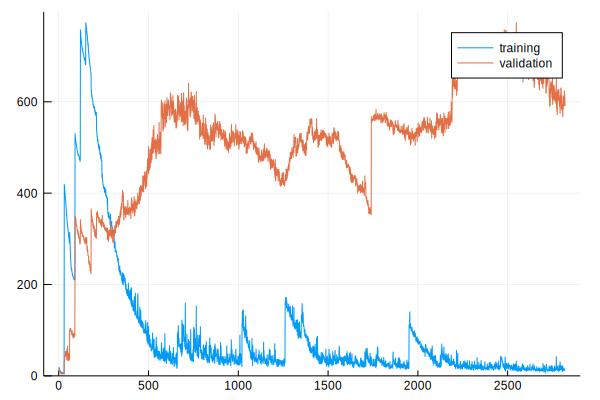

 85.167544 seconds (18.87 M allocations: 2.552 GiB, 1.23% gc time)


Progress:  94%|███████████████████████████████████████  |  ETA: 0:34:11

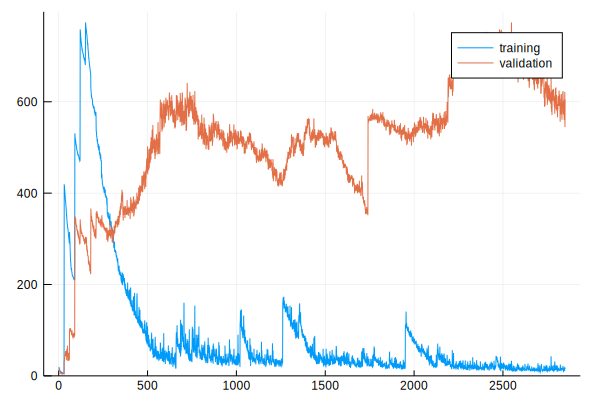

101.333125 seconds (19.14 M allocations: 2.589 GiB, 1.13% gc time)


Progress:  95%|███████████████████████████████████████  |  ETA: 0:28:35

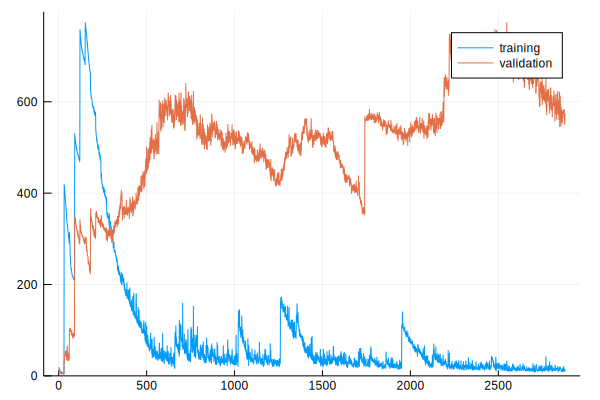

110.602334 seconds (19.23 M allocations: 2.601 GiB, 1.08% gc time)


Progress:  96%|███████████████████████████████████████  |  ETA: 0:22:46

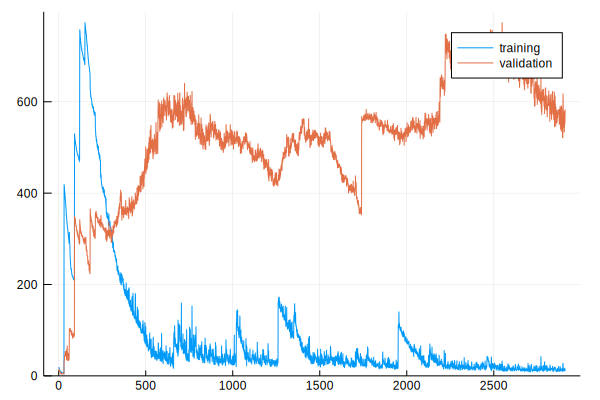

 97.498945 seconds (19.70 M allocations: 2.663 GiB, 1.25% gc time)


Progress:  97%|████████████████████████████████████████ |  ETA: 0:17:10

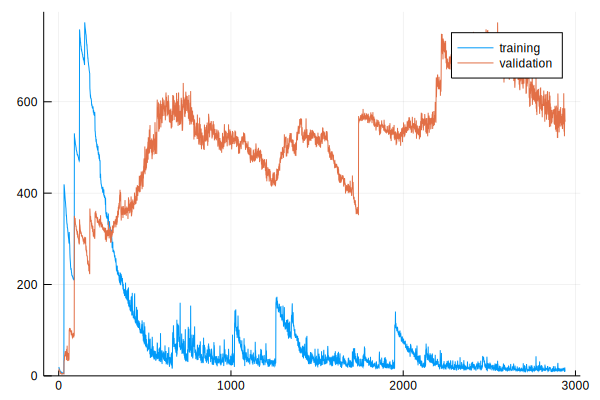

 96.780566 seconds (19.87 M allocations: 2.687 GiB, 1.17% gc time)


Progress:  98%|████████████████████████████████████████ |  ETA: 0:11:26

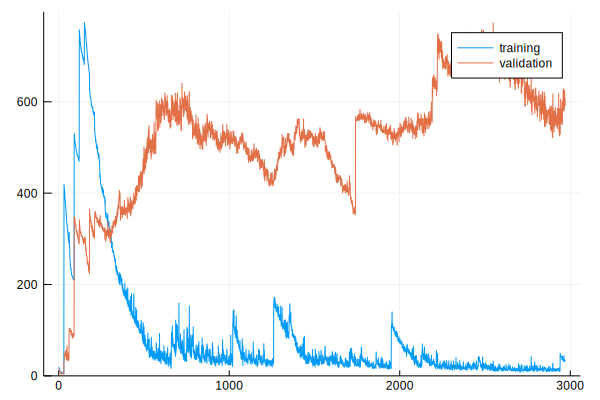

100.624001 seconds (20.17 M allocations: 2.726 GiB, 1.18% gc time)


Progress:  99%|█████████████████████████████████████████|  ETA: 0:05:43

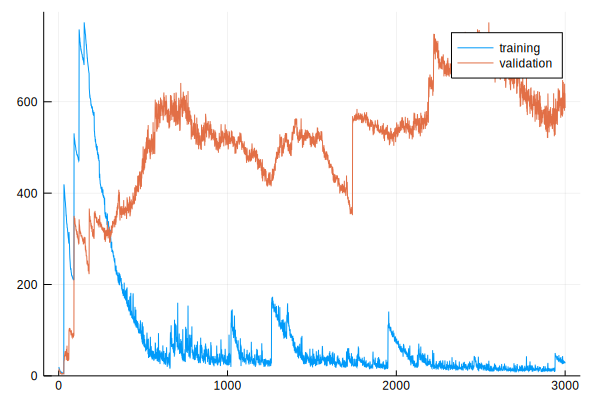

 91.310626 seconds (20.30 M allocations: 2.744 GiB, 1.23% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 9:32:08


In [6]:
datasets = Vector{LearningMPC.Dataset{Float64}}()
all_training_data = Vector{Tuple{Vector{Float64}, Float64, Float64}}()
all_validation_data = Vector{Tuple{Vector{Float64}, Float64, Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

N_iter = 100
σv = 3.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    for i in 1:2
        collect_into!(dataset.training_data, i / N_iter * σv)
    end
    collect_into!(dataset.testing_data, i / N_iter * σv)
    collect_into!(dataset.validation_data, i / N_iter * σv)
    append!(all_training_data, features.(dataset.training_data))
    append!(all_validation_data, features.(dataset.validation_data))
    filter!(all_training_data) do sample
        all(isfinite, sample[1]) && isfinite(sample[2]) && isfinite(sample[3])
    end
    filter!(all_validation_data) do sample
        all(isfinite, sample[1]) && isfinite(sample[2]) && isfinite(sample[3])
    end
    
    @time for i in 1:30
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen("boxatlas.jld2", "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt,
            "horizon" => params.horizon,
        )
        file["all_training_data"] = all_training_data
        file["all_validation_data"] = all_validation_data
        file["losses"] = losses
    end
    
    plt = plot(first.(losses), label="training")
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (0, ylims(plt)[2]))
    display(plt)
end

In [7]:
x0 = nominal_state(robot)
set_velocity!(x0, findjoint(robot.mechanism, "floating_base"), [-0.5, 0, 0])
results = LCPSim.simulate(x0, net_mpc_controller, environment(robot), 0.01, 300, params.lcp_solver);

setanimation!(mvis, results)



true